#### In the Exploratory Data Analysis (EDA) section of a repository dedicated to the Cora dataset, the focus would be on understanding the characteristics of the dataset's graph structure. Here's a detailed explanation that could be included:

In [5]:
#Import Libraries
import pandas as pd
import networkx as nx
import os
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [6]:
# Load the content file into a DataFrame
content_df = pd.read_csv(r'..\data\cora\cora.content', sep='\t', header=None)
cites_df = pd.read_csv(r'..\data\cora\cora.content', sep='\t', header=None, names=['cited', 'citing'])

In [7]:
# all columns except the first (ID) and last (class label)
# last column is the class label
# first column is the paper ID
features = content_df.iloc[:, 1:-1] 
labels = content_df.iloc[:, -1]  
paper_ids = content_df.iloc[:, 0] 

In [8]:
# Frequency of each class label
# Frequency of citations for each paper
print(content_df.iloc[:, -1].value_counts())  
print(cites_df['cited'].value_counts())       


Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: 1434, dtype: int64
0    2696
1      12
Name: cited, dtype: int64


In [9]:
# Create the graph
G = nx.from_pandas_edgelist(cites_df, 'citing', 'cited', create_using=nx.DiGraph())

# Output the statistics
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Classes: {len(labels.unique())}")
print(f"Features: {features.shape[1]}")


Nodes: 9
Edges: 10
Classes: 7
Features: 1433


In [10]:
# Check for missing values
print(content_df.isnull().sum())
print(cites_df.isnull().sum())

0       0
1       0
2       0
3       0
4       0
       ..
1430    0
1431    0
1432    0
1433    0
1434    0
Length: 1435, dtype: int64
cited     0
citing    0
dtype: int64


## EDA with Planetoid 
The citation network datasets "Cora"from the “Revisiting Semi-Supervised Learning with Graph Embeddings” paper (Yang et al. 2016)

In [11]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

# Print basic information about the dataset
print("Dataset:", dataset)
print("Number of graphs:", len(dataset))
print("Number of features:", dataset.num_features)
print("Number of classes:", dataset.num_classes)


Processing...


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [12]:
# The total number of papers included in the dataset.
print(f'Number of nodes: {data.num_nodes}')
# Each edge indicates a citation from one paper to another. The total number of citations in the dataset is number of edges
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  
# Self-loops would indicate a paper citing itself.
print(f'Has self-loops: {data.has_self_loops()}')  
print(f'Is undirected: {data.is_undirected()}')  
# The average node degree indicates the average number of citations per paper (both incoming and outgoing if the network is considered undirected).
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90


**Isolated Nodes:**
Isolated nodes are papers that do not cite other papers in the dataset nor are they cited by papers within the dataset. The absence of isolated nodes (False output) suggests that all papers in the Cora dataset are at least minimally connected, enhancing the potential for link prediction and community detection tasks.

**Self-Loops:** The Cora dataset generally does not include self-loops (False output), which is typical for most academic citation networks.

**Directed vs Undirected:** Typically, citation networks are directed, meaning if paper A cites paper B, the inverse may not be true. However, for some types of analysis, this network is treated as undirected (True output), which simplifies the connectivity and is useful in certain algorithms that require undirected graphs.

**Average Node Degree:**  A higher average node degree suggests a highly interconnected set of papers, which can be beneficial for information spreading and clustering algorithms.

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


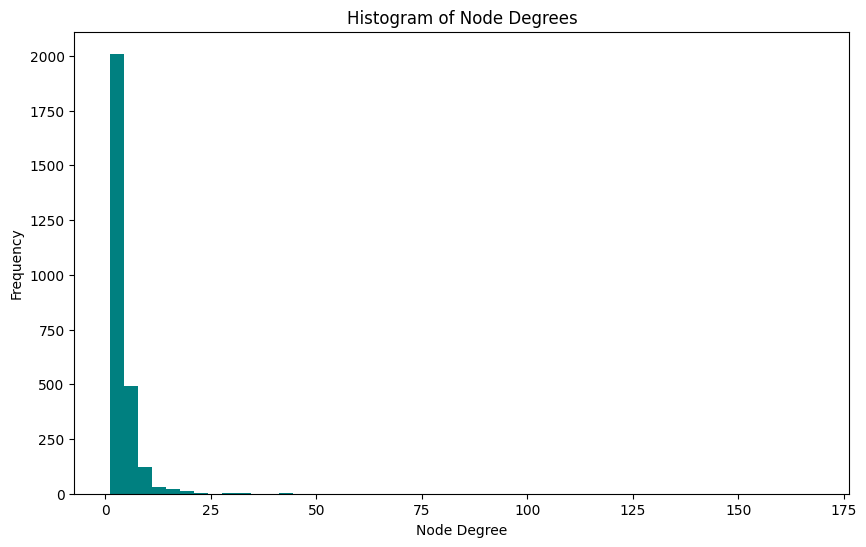

In [13]:
G = to_networkx(data, to_undirected=True)

# Calculate degrees of nodes
degrees = [val for (node, val) in G.degree()]

# Display statistics
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

# Output number of degrees and their sum
print(len(degrees))
print(sum(degrees))

# Visualizing the degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='teal')  # Specifying color as 'teal'
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Node Degrees")
plt.show()


A high degree indicates that a node (paper) has numerous connections with other nodes. Typically, nodes with higher degrees are considered significant within the network. The number of citations a paper receives can serve as a rough indicator of its influence or quality.

Let's visualize the graph to identify the positions of the top 10 nodes that have the highest degrees:

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


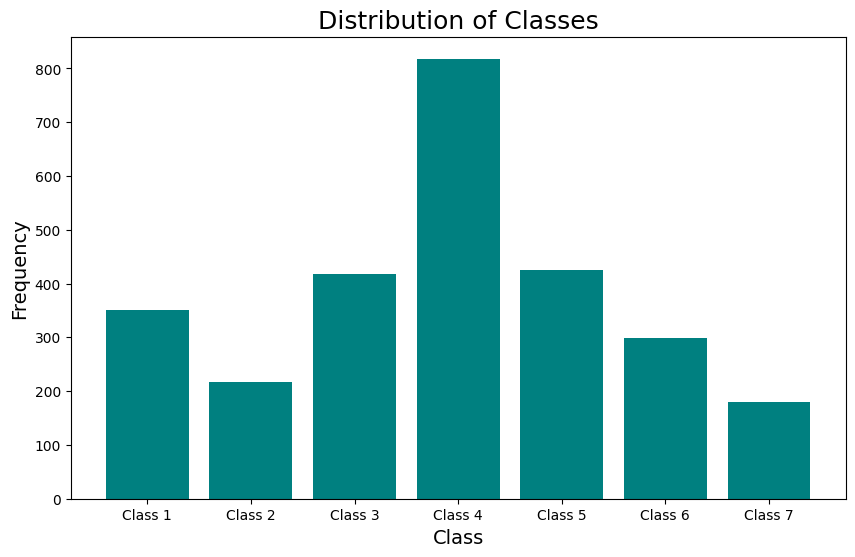

In [14]:
# Assuming 'data.y.numpy()' returns an array of class labels
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a bar chart with teal colored bars
plt.bar(range(7), count, color='teal')  # Setting the bar color to teal
plt.xlabel("Class", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Classes", size=18)
plt.xticks(range(7), [f'Class {i}' for i in range(1, 8)])  # Assuming classes are labeled from 1 to 7

# Display the plot
plt.show()


Class 3 contains 818 papers, making it the class with the most papers while Class 6 contains 180 papers, making it the class with the fewest papers.

A network diagram to see class distribution:

In [15]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

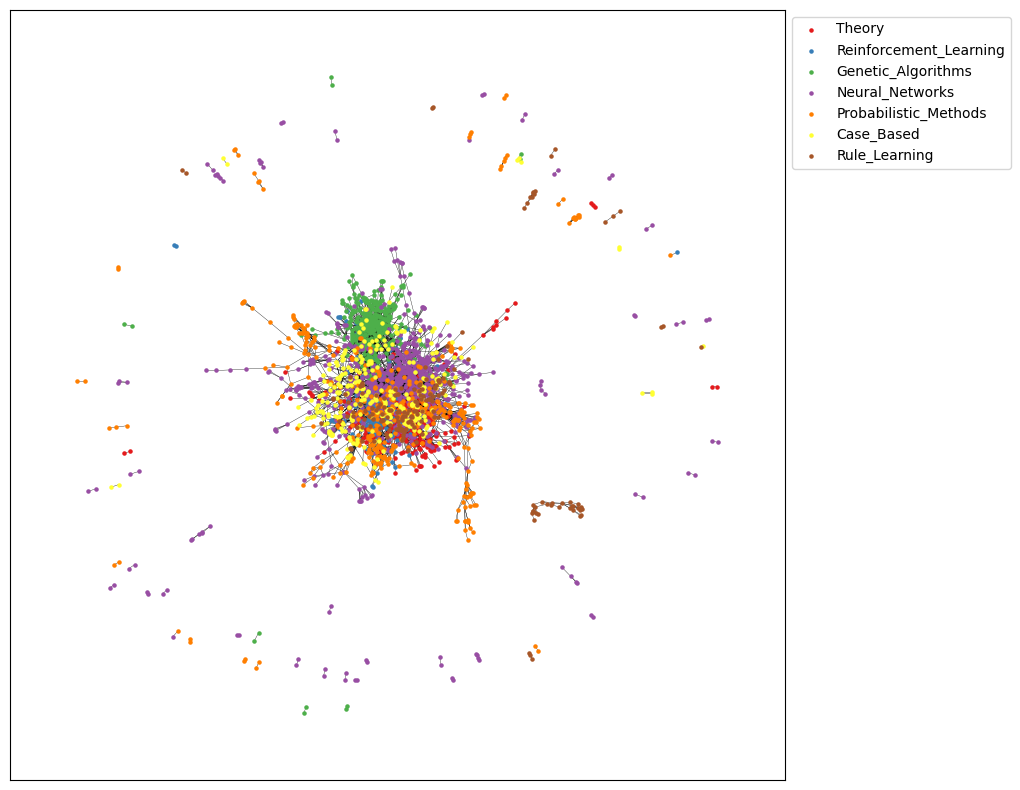

In [16]:
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

Nodes that share similar characteristics tend to be connected, a phenomenon known as homophily. For the seven classes previously discussed, I will examine the extent to which nodes within the same class are interconnected by edges, as well as the reverse scenario.

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


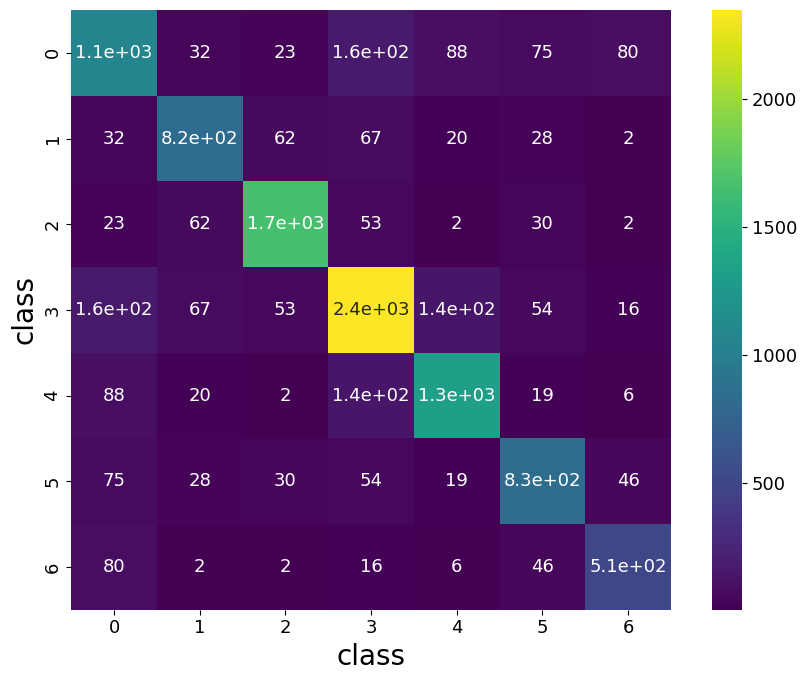

In [17]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='viridis', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

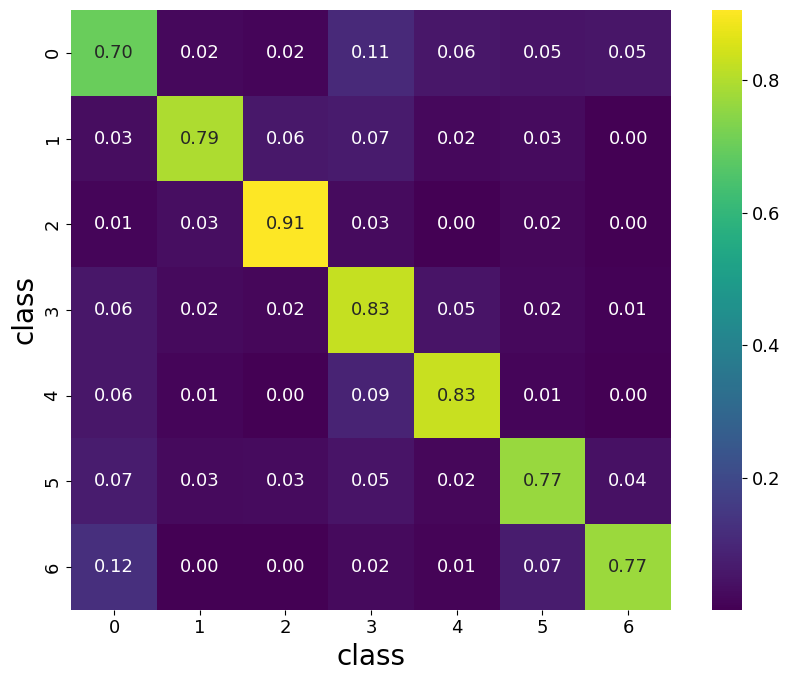

In [19]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='viridis',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

 The analysis reveals that for all classes, the majority of edges are connected within the same class. This trend is most pronounced in Class 2, where approximately 91% of the edges connect nodes within the same class. Conversely, the trend is less pronounced in Class 0, where only about 70% of the edges are within the same class.

Based on the paper 'Revisiting Semi-Supervised Learning with Graph Embeddings' by Yang et al. (2016), the dataset is split using the Planetoid method. 

In [20]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [21]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3

The training dataset is balanced, whereas the validation and test datasets mirror the overall distribution of the dataset. This approach not only facilitates learning from a balanced dataset but also enhances the ability to evaluate the model's generalizability, as the validation and test datasets maintain a consistent distribution. This balancing of the training data, along with the implementation of cross-validation for node classification, are key reasons for the design choices made in this repository.

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


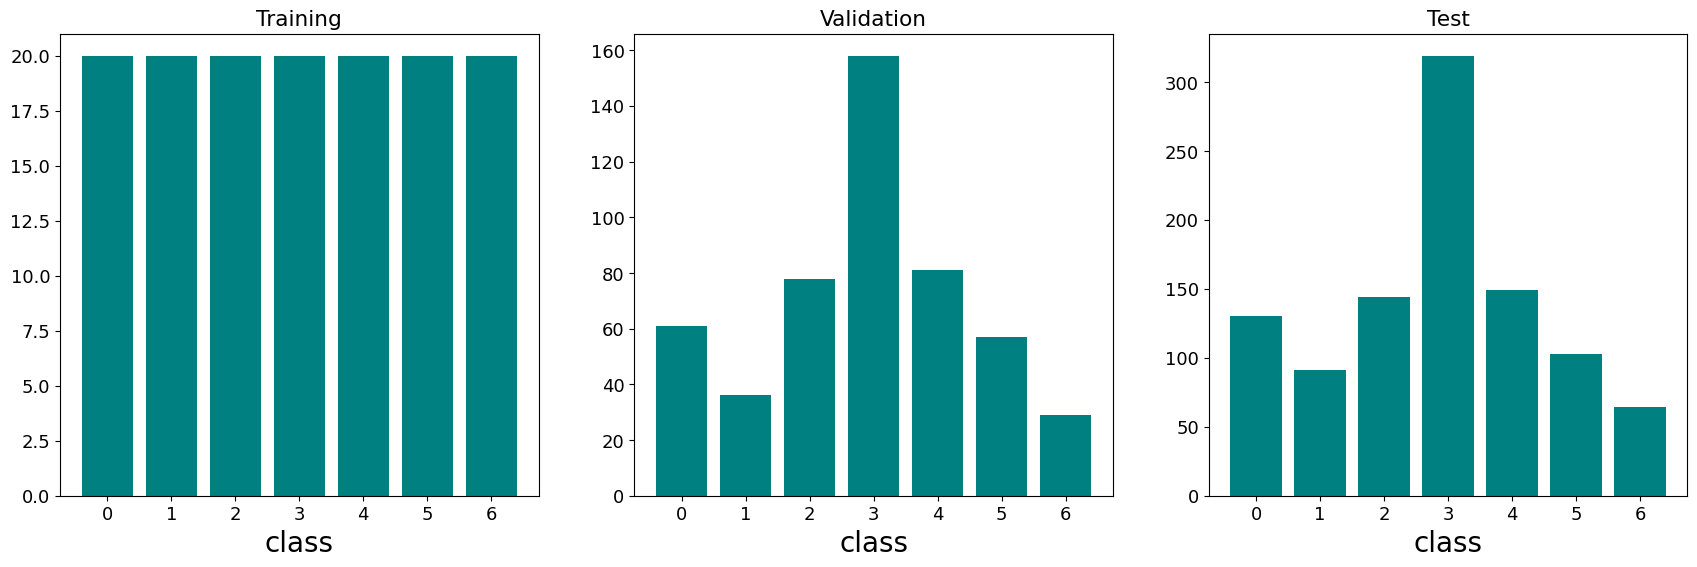

In [25]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))

for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    
    count = [x[1] for x in sorted(counter.items())]
    axes[i].bar(range(len(counter)), count, color='teal')  # Set the color to teal here
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])

plt.show()
